# Baseline model

This notebook contains the model that we will use as a baseline to compare all others. The architecture we will deploy is a simple CNN. This model will be trained and tested over partitions of the the COCO 2014 training dataset. 

TO DO:
- fix predicted images (see output alla fine)

## Libraries import

In [1]:
import torch
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
from tqdm import tqdm
import torch.optim as optim
# our modules
from utils.dataset import CocoDataset
from utils.plots import plot_l, plot_a, plot_b, plot_rgb, reconstruct_lab

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Data import

In [3]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(), # tensorization brings image in range [0,1] and space CxHxW
])

In [4]:
path_sandro = "coco/images/train2014"
path_diego = "C:/Users/diego/coco/images/train2014/train2014"
dataset = CocoDataset(root=path_sandro, transform=transform)

Found 82783 images.


In [5]:
len(dataset)

82783

In [6]:
image, l_channel, a_channel, b_channel, ab_channels = dataset[0]

In [7]:
type(image), type(l_channel), type(a_channel), type(b_channel), type(ab_channels)

(torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor)

In [8]:
image.shape, l_channel.shape, a_channel.shape, b_channel.shape, ab_channels.shape

(torch.Size([3, 64, 64]),
 torch.Size([1, 64, 64]),
 torch.Size([64, 64]),
 torch.Size([64, 64]),
 torch.Size([2, 64, 64]))

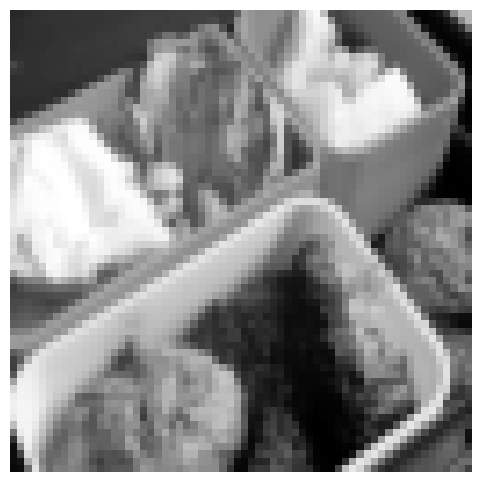

In [9]:
plot_l(l_channel)

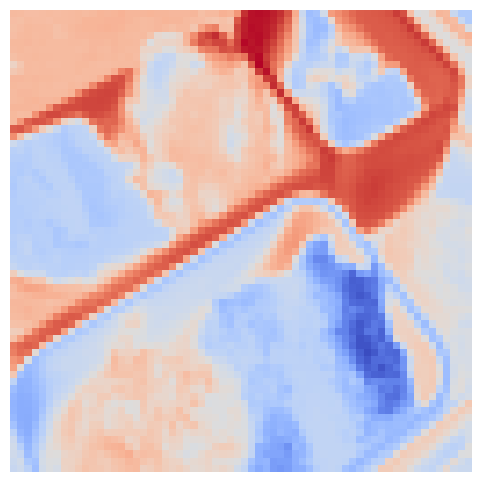

In [10]:
plot_a(a_channel)

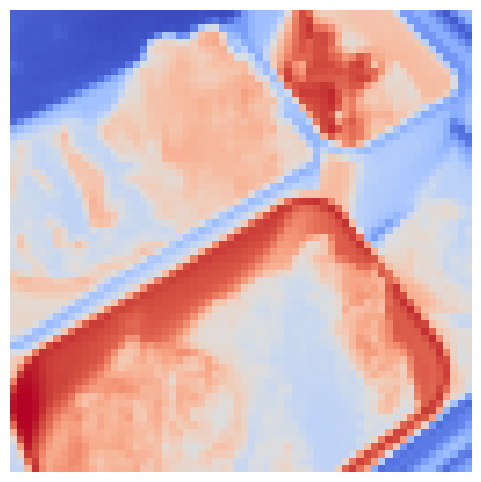

In [11]:
plot_b(b_channel)

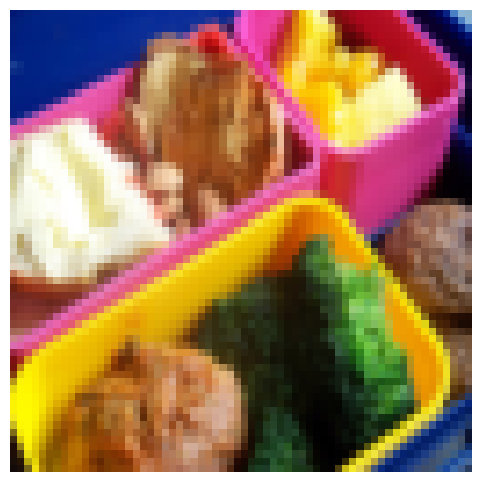

In [12]:
plot_rgb(image)

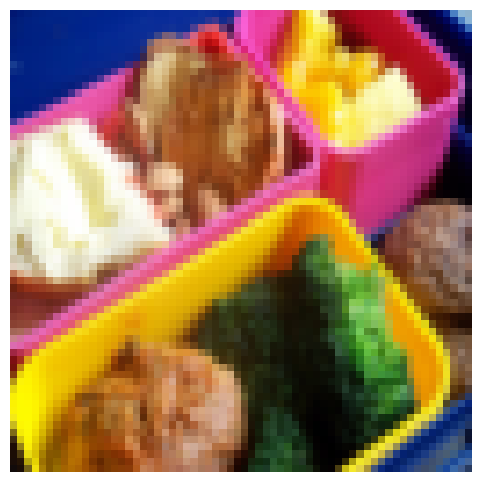

In [13]:
reconstruct_lab(l_channel, ab_channels)

## Data preparation

We split our dataset in train and test data.

In [14]:
test_size = int(0.2 * len(dataset))
train_size = len(dataset) - test_size

In [16]:
torch.manual_seed(42)
train, test = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train, batch_size=64, shuffle=True)
test_loader = DataLoader(test, batch_size=64, shuffle=True)

In [35]:
for x in train_loader:
    print(x)
    break

[tensor([[[[0.0392, 0.0471, 0.0549,  ..., 0.0235, 0.0039, 0.0039],
          [0.0392, 0.0510, 0.0588,  ..., 0.0196, 0.0039, 0.0039],
          [0.0431, 0.0510, 0.0627,  ..., 0.0157, 0.0039, 0.0039],
          ...,
          [0.0118, 0.0078, 0.0000,  ..., 0.0196, 0.0745, 0.1333],
          [0.0118, 0.0118, 0.0078,  ..., 0.0392, 0.0902, 0.1333],
          [0.0157, 0.0118, 0.0275,  ..., 0.0392, 0.1020, 0.1373]],

         [[0.0275, 0.0196, 0.0275,  ..., 0.1020, 0.0118, 0.0039],
          [0.0314, 0.0196, 0.0314,  ..., 0.0784, 0.0039, 0.0039],
          [0.0353, 0.0196, 0.0353,  ..., 0.0627, 0.0039, 0.0039],
          ...,
          [0.0039, 0.0078, 0.0039,  ..., 0.0196, 0.0627, 0.1059],
          [0.0039, 0.0039, 0.0039,  ..., 0.0431, 0.0784, 0.1059],
          [0.0078, 0.0078, 0.0118,  ..., 0.0431, 0.0902, 0.1098]],

         [[0.0275, 0.0118, 0.0157,  ..., 0.1451, 0.0275, 0.0118],
          [0.0275, 0.0118, 0.0196,  ..., 0.1137, 0.0196, 0.0118],
          [0.0431, 0.0157, 0.0235,  ..., 

## CNN Model

For the moment, we will work with a small subset of the training data

In [16]:
torch.manual_seed(42)
train_size = 5000
small_train, _ = random_split(train, [train_size, len(train) - train_size])
small_train_loader = DataLoader(small_train, batch_size=64, shuffle=True, num_workers=0)
test_size = 1000
small_test, _ = random_split(test, [test_size, len(test) - test_size])
small_test_loader = DataLoader(small_test, batch_size=64, shuffle=True, num_workers=0)

In [17]:
class ColorizationCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(32, 2, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = self.relu(self.conv5(x))
        x = self.relu(self.conv6(x))
        return self.sigmoid(x)

## Training

In [18]:
model = ColorizationCNN().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [19]:
NUM_EPOCHS = 10
train_losses = []
test_losses = []

for epoch in range(NUM_EPOCHS):
    running_loss = 0.0
    test_loss = 0.0

    # train loop
    model.train()
    progress_bar = tqdm(small_train_loader, desc=f'Epoch {epoch + 1}/{NUM_EPOCHS}', leave=True)
    for _, l_channels, ab_channels in progress_bar:
        l_channels = l_channels.to(device)
        ab_channels = ab_channels.to(device)
        
        optimizer.zero_grad()
        outputs = model(l_channels)
        loss = criterion(outputs, ab_channels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        progress_bar.set_postfix(loss=(running_loss / (progress_bar.n + 1)))
    
    train_losses.append(running_loss / len(small_train_loader))
    print(f"Epoch {epoch + 1}, Train Loss: {train_losses[-1]}")
    
    # test loop
    model.eval()
    with torch.no_grad():
        for _, l_channels, ab_channels in tqdm(small_test_loader, desc='Testing', leave=True):
            l_channels = l_channels.to(device)
            ab_channels = ab_channels.to(device)
            
            outputs = model(l_channels)
            loss = criterion(outputs, ab_channels)
            test_loss += loss.item()
        
    test_loss /= len(small_test_loader)
    test_losses.append(test_loss)
    print(f"Epoch {epoch + 1}, Validation Loss: {test_loss}")
    
print('Finished Training')

Epoch 1/10:   0%|          | 0/79 [00:00<?, ?it/s]


ValueError: too many values to unpack (expected 3)

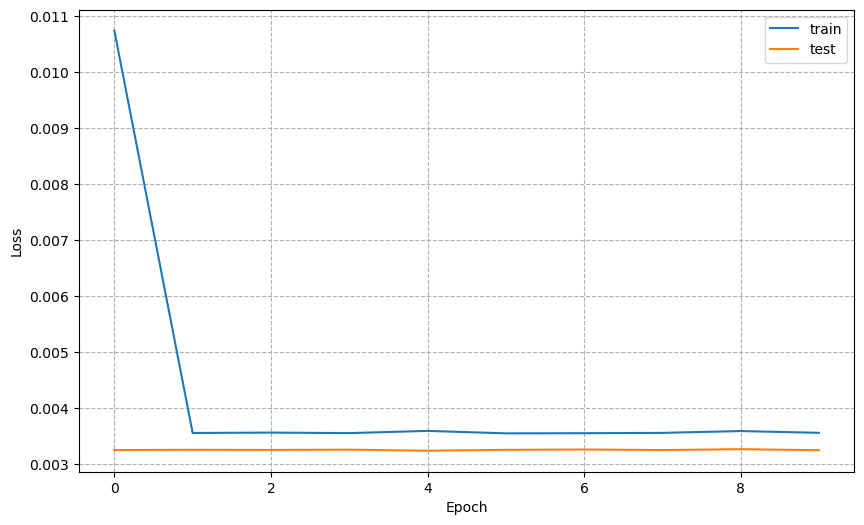

In [20]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(linestyle = "--")
plt.legend()
plt.show()

# Save and Load Model

In [49]:
# save weights
# run only if necessary... scriviamo una funzione anche per questa in futuro
from pathlib import Path
PATH = Path("models") 
PATH.mkdir(parents=True, # create parent directories if needed
           exist_ok=True # if models directory already exists, don't error
)
MODEL_NAME = "cnn_basic_1.pth"
MODEL_PATH = PATH / MODEL_NAME
torch.save(obj=model.state_dict(), f=MODEL_PATH)
print(f"Model saved to {MODEL_PATH} succesfully!")

Model saved to models\cnn_basic_1.pth succesfully!


In [48]:
model._get_name()

'ColorizationCNN'

In [51]:
# load model
# start from here if you don't want to do training again
loaded_model = ColorizationCNN() # create instance
loaded_model.load_state_dict(torch.load(f=MODEL_PATH)) # upload weights
print(f"{loaded_model._get_name()} model uploaded succesfully!")
loaded_model= loaded_model.to(device) # send it to gpu

ColorizationCNN model uploaded succesfully!


# Test with Image

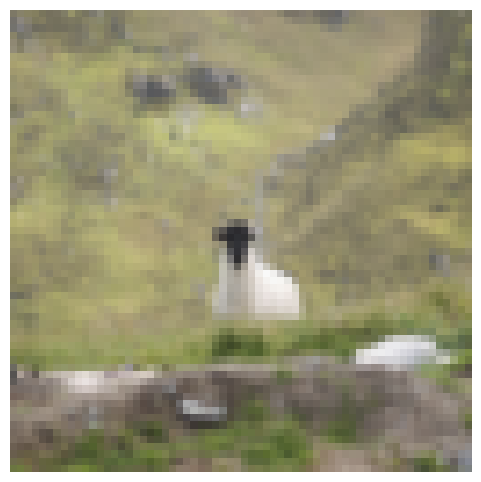

In [24]:
dataset.plot_rgb(50001)

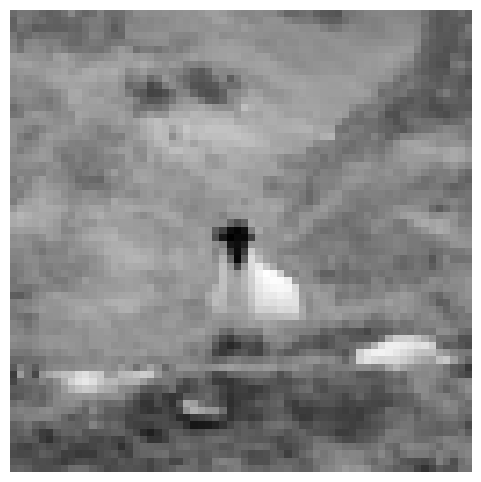

In [25]:
dataset.plot_l(50001)

In [52]:
l_test = dataset.get_channels_for_image(50001)[0].to(device)
ab_pred_test = loaded_model(l_test)

In [53]:
ab_pred_test.shape

torch.Size([2, 64, 64])

In [54]:
ab_pred_test

tensor([[[0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
         ...,
         [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000]],

        [[0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
         ...,
         [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000]]],
       device='cuda:0', grad_fn=<SigmoidBackward0>)

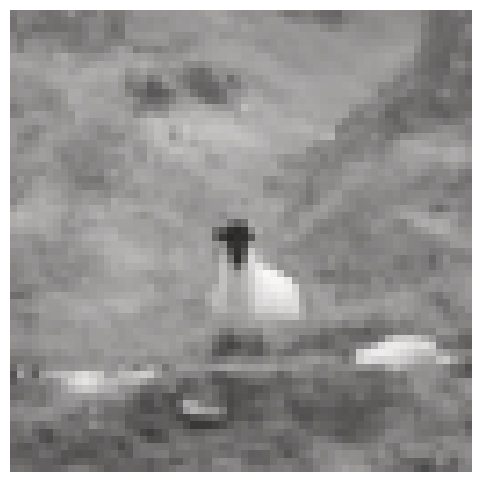

In [55]:
reconstruct_lab(l_test.detach().cpu(), ab_pred_test.detach().cpu())
# non colorata...

In [56]:
ab_pred_test.unique() # tensor([0.5000], device='cuda:0', grad_fn=<Unique2Backward0>), sono tutti 0.5
# questo spiegherebbe la loss così basssa.... non sta colorando

tensor([0.5000], device='cuda:0', grad_fn=<Unique2Backward0>)